# Importing Libraries

In [ ]:
# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# General libraries for data handling and manipulation
import numpy as np
import pandas as pd
import os


# Uploading Files and Setting Directory

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [ ]:
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Extract to a 'dataset' folder


In [ ]:
import os

# Verify the directory structure
print(os.listdir('dataset/images/train'))  # Should list emotion folders in train
print(os.listdir('dataset/images/validation'))   # Should list emotion folders in test


['disgust', 'fear', 'angry', 'neutral', 'sad', 'happy', 'surprise']
['disgust', 'fear', 'angry', 'neutral', 'sad', 'happy', 'surprise']


In [ ]:
TRAIN_DIR = 'dataset/images/train'
TEST_DIR = 'dataset/images/validation'


# Preparing Dataset: Image Paths and Labels

In [ ]:
def createdataframe(dir):
    image_paths = []  # List to store the paths of all images
    labels = []       # List to store the corresponding labels for each image

    # Loop over all the directories (labels) in the given directory
    for label in os.listdir(dir):
        # Loop over all images in each label folder
        for imagename in os.listdir(os.path.join(dir, label)):
            # Construct the full path of the image
            image_paths.append(os.path.join(dir, label, imagename))
            # Append the label (emotion) corresponding to this image
            labels.append(label)

        print(label, "completed")  # Indicating the label (emotion) folder has been processed

    return image_paths, labels  # Return the lists of image paths and labels


In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

disgust completed
fear completed
angry completed
neutral completed
sad completed
happy completed
surprise completed


In [ ]:
print(train)

                                         image     label
0       dataset/images/train/disgust/19257.jpg   disgust
1        dataset/images/train/disgust/1073.jpg   disgust
2       dataset/images/train/disgust/10236.jpg   disgust
3        dataset/images/train/disgust/5335.jpg   disgust
4        dataset/images/train/disgust/4889.jpg   disgust
...                                        ...       ...
28816    dataset/images/train/surprise/332.jpg  surprise
28817  dataset/images/train/surprise/29747.jpg  surprise
28818  dataset/images/train/surprise/35540.jpg  surprise
28819  dataset/images/train/surprise/21995.jpg  surprise
28820  dataset/images/train/surprise/23899.jpg  surprise

[28821 rows x 2 columns]


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

disgust completed
fear completed
angry completed
neutral completed
sad completed
happy completed
surprise completed


In [ ]:
print(test)

                                             image     label
0      dataset/images/validation/disgust/28332.jpg   disgust
1       dataset/images/validation/disgust/9043.jpg   disgust
2      dataset/images/validation/disgust/31796.jpg   disgust
3       dataset/images/validation/disgust/7068.jpg   disgust
4      dataset/images/validation/disgust/35376.jpg   disgust
...                                            ...       ...
7061  dataset/images/validation/surprise/11126.jpg  surprise
7062  dataset/images/validation/surprise/31781.jpg  surprise
7063   dataset/images/validation/surprise/6360.jpg  surprise
7064  dataset/images/validation/surprise/23053.jpg  surprise
7065   dataset/images/validation/surprise/5636.jpg  surprise

[7066 rows x 2 columns]


# Feature Extraction

In [ ]:
from tqdm.notebook import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        # Use color_mode='grayscale' instead of grayscale=True
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features


In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

# Scaling the Data

In [ ]:
x_train = train_features/255.0
x_test = test_features/255.0

# One Hot Encoding the Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit the encoder on the training labels
le.fit(train['label'])

# Transform the labels into numerical values
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])


In [ ]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Building and Compiling the Model

In [ ]:
from keras.layers import Activation
model = Sequential()
# Convolutional layers with batch normalization
model.add(Conv2D(128, kernel_size=(3,3), input_shape=(48,48,1)))
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply activation after normalization
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers with batch normalization
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(7, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Training the Model

In [ ]:
model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 50, validation_data = (x_test,y_test))

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6395 - loss: 0.9454 - val_accuracy: 0.5633 - val_loss: 1.1858
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6498 - loss: 0.9146 - val_accuracy: 0.5894 - val_loss: 1.1082
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.6551 - loss: 0.9226 - val_accuracy: 0.5863 - val_loss: 1.1114
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.6704 - loss: 0.8754 - val_accuracy: 0.5761 - val_loss: 1.1363
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6846 - loss: 0.8555 - val_accuracy: 0.5638 - val_loss: 1.1767
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6876 - loss: 0.8387 - val_accuracy: 0.6044 - val_loss: 1.1104
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.7005 - loss: 0.8132 - val_accuracy: 0.5918 - val_loss: 1.1248
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.6988 - loss: 0.7934 - 

In [ ]:
from tensorflow.keras.models import load_model

# Save the full model (architecture + weights)
model.save("emotion_model.keras")


# Making Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
Model prediction: sad


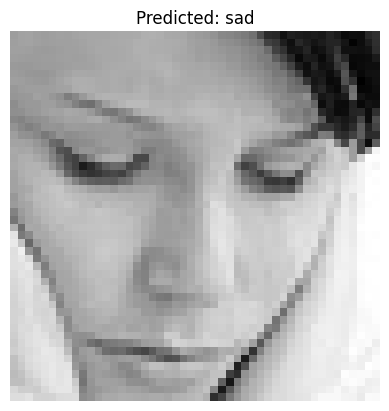

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Your label names
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Function to preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img = img_to_array(img)
    img = img.reshape(1, 48, 48, 1)  # Add batch & channel dims
    img = img / 255.0
    return img

# Path to your test image (update this! after uploading)
image_path = '42.jpg'  # Use the name of the uploaded image
img = preprocess_image(image_path)

# Predict
pred = model.predict(img)
pred_label = labels[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image with the predicted label
img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))  # Re-load image for display
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {pred_label}")
plt.axis('off')  # Turn off axes
plt.show()


In [ ]:
from google.colab import files
files.download('/content/emotion_model.keras')  # Download to your computer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>